# Simple Ising Model Example

This notebook demonstrates:
1. Creating an Ising model (from SpinSystems submodule)
2. Setting up a Metropolis algorithm with Boltzmann weights
3. Configuring measurements with the new measurement framework
4. Running equilibrium Monte Carlo simulation
5. Analyzing results

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
Pkg.instantiate()

using Random
using StatsBase
using MonteCarloX
using SpinSystems

  Activating project at `~/.julia/dev/MonteCarloX`
Precompiling packages...
   1100.7 ms  ✓ MonteCarloX
   1630.9 ms  ✓ SpinSystems
  2 dependencies successfully precompiled in 5 seconds. 235 already precompiled.


## Setup System and Algorithm

In [2]:
# Setup
rng = MersenneTwister(42)
L = 8
# Create Ising system
sys = Ising([L, L], J=1, periodic=true)
init!(sys, :random, rng=rng)

println("System configuration:")
println("  Lattice size: $(L)×$(L)")
println("  Total spins: $(L*L)")
println("  Spins from system: $(size(sys.spins))")

# Create Metropolis algorithm with Boltzmann weight
β = 0.3  # Inverse temperature
alg = Metropolis(rng, β=β)
println("  Inverse temperature β: $β")

System configuration:
  Lattice size: 8×8
  Total spins: 64
  Spins from system: (64,)
  Inverse temperature β: 0.3


## Configure Measurements

In [3]:
# Setup measurements
measurements = Measurements([
    :energy => energy => Float64[],
    :magnetization => magnetization => Float64[]
], interval=10)

Measurements{Symbol, IntervalSchedule}(Dict{Symbol, Measurement}(:energy => Measurement{typeof(energy), Vector{Float64}}(SpinSystems.energy, Float64[]), :magnetization => Measurement{typeof(magnetization), Vector{Float64}}(SpinSystems.magnetization, Float64[])), IntervalSchedule(10.0, 0.0))

## Benchmark code

In [4]:
# benchmark the spinflip here
using BenchmarkTools
@btime spin_flip!(sys, alg)

  56.937 ns (0 allocations: 0 bytes)


In [5]:
# more details on the performance and calls
@code_warntype spin_flip!(sys, alg)

MethodInstance for spin_flip!(::Ising{Int64}, ::Metropolis{BoltzmannLogWeight{Float64}, MersenneTwister})
  from spin_flip!(sys::SpinSystems.AbstractIsing, alg::AbstractImportanceSampling) @ SpinSystems ~/.julia/dev/MonteCarloX/SpinSystems/src/ising.jl:162
Arguments
  #self#::Core.Const(SpinSystems.spin_flip!)
  sys::Ising{Int64}
  alg::Metropolis{BoltzmannLogWeight{Float64}, MersenneTwister}
Locals
  log_ratio::Float64
  ΔE::Int64
  i::UInt64
Body::Nothing
1 ─ %1  = SpinSystems.pick_site::Core.Const(SpinSystems.pick_site)
│   %2  = Base.getproperty(alg, :rng)::MersenneTwister
│   %3  = SpinSystems.length::Core.Const(length)
│   %4  = Base.getproperty(sys, :spins)::Vector{Int8}
│   %5  = (%3)(%4)::Int64
│         (i = (%1)(%2, %5))
│   %7  = SpinSystems.delta_energy::Core.Const(SpinSystems.delta_energy)
│   %8  = i::UInt64
│         (ΔE = (%7)(sys, %8))
│   %10 = Base.getproperty(alg, :logweight)::BoltzmannLogWeight{Float64}
│   %11 = ΔE::Int64
│         (log_ratio = (%10)(%11))
│   %1

In [7]:
# opimized code
sys_optim = Ising_2Dgrid_optim(L, L)
@btime spin_flip!(sys_optim, alg)

  57.887 ns (0 allocations: 0 bytes)


## Run Simulation

In [4]:
# Thermalization
println("Thermalizing...")
N = L * L
for i in 1:N*1000
    spin_flip!(sys, alg)
end
println("  Thermalization complete: $(alg.steps) steps")

# Reset statistics after thermalization
reset_statistics!(alg)

Thermalizing...
  Thermalization complete: 64000 steps


0

In [5]:
# Production run
println("Production run...")
for i in 1:N*10000
    spin_flip!(sys, alg)
    measure!(measurements, sys, i)
end

Production run...


## Analyze Results

In [8]:
energies = measurements[:energy].data
mags = measurements[:magnetization].data

avg_E = mean(energies) / N
avg_M = mean(mags) / N

println("\nResults:")
println("  Total steps: $(alg.steps)")
println("  Acceptance rate: $(round(acceptance_rate(alg), digits=4))")
println("\nObservables (per spin):")
println("  Average energy: $(round(avg_E, digits=4))")
println("  Average magnetization: $(round(avg_M, digits=4))")


Results:
  Total steps: 10280501
  Acceptance rate: 0.5182

Observables (per spin):
  Average energy: -0.7225
  Average magnetization: 0.2838


## Energy Time Series

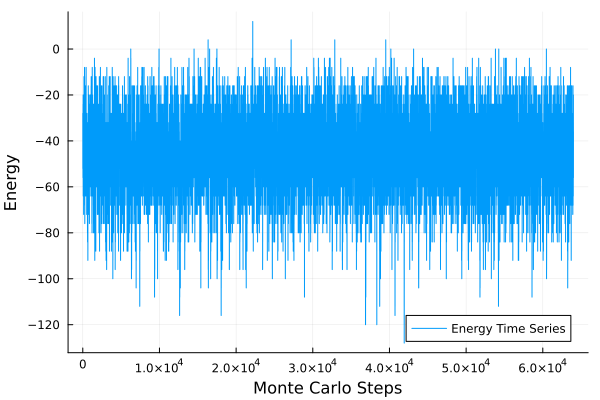

In [9]:
using Plots
energies = measurements[:energy].data
plot(energies, label="Energy Time Series", xlabel="Monte Carlo Steps", ylabel="Energy")

## Energy Distribution vs Exact (Beale 8x8)

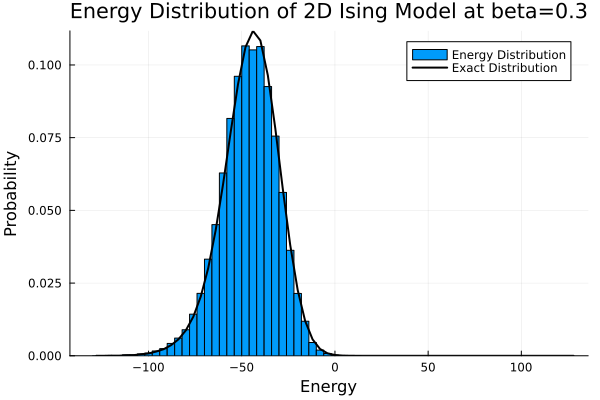

In [10]:
log_dos_beale_8x8 = [ (-128, 0.6931471805599453), (-124, 0.0), (-120, 4.852030263919617), (-116, 5.545177444479562), (-112, 8.449342524508063), (-108, 9.793672686528922), (-104, 11.887298863200714), (-100, 13.477180596840947), (-96, 15.268195474147658), (-92, 16.912371686315282), (-88, 18.59085846191256), (-84, 20.230089202801466), (-80, 21.870810400320693), (-76, 23.498562234123614), (-72, 25.114602234581373), (-68, 26.70699035290573), (-64, 28.266152815389898), (-60, 29.780704423363996), (-56, 31.241053997806176), (-52, 32.63856452513369), (-48, 33.96613536105969), (-44, 35.217576663643314), (-40, 36.3873411250109), (-36, 37.47007844691906), (-32, 38.46041522581422), (-28, 39.35282710786369), (-24, 40.141667825183845), (-20, 40.82130289691285), (-16, 41.38631975325592), (-12, 41.831753810069756), (-8, 42.153328313883975), (-4, 42.34770636939425), (0, 42.41274640460084), (4, 42.34770636939425), (8, 42.153328313883975), (12, 41.831753810069756), (16, 41.38631975325592), (20, 40.82130289691285), (24, 40.141667825183845), (28, 39.35282710786369), (32, 38.46041522581422), (36, 37.47007844691906), (40, 36.3873411250109), (44, 35.217576663643314), (48, 33.96613536105969), (52, 32.63856452513369), (56, 31.241053997806176), (60, 29.780704423363996), (64, 28.266152815389898), (68, 26.70699035290573), (72, 25.114602234581373), (76, 23.498562234123614), (80, 21.870810400320693), (84, 20.230089202801466), (88, 18.59085846191256), (92, 16.912371686315282), (96, 15.268195474147658), (100, 13.477180596840947), (104, 11.887298863200714), (108, 9.793672686528922), (112, 8.449342524508063), (116, 5.545177444479562), (120, 4.852030263919617), (124, 0.0), (128, 0.6931471805599453) ];
struct BoltzmannDistribution
    pdf::Dict{Any,Float64}
    function log_sum(a::Number, b::Number)::Float64
        if b < a
            return a + log(1 + exp(b - a))
        else
            return b + log(1 + exp(a - b))
        end
    end
    function initialize_BoltzmannDistribution(beta, log_dos)
        log_Z = -Inf
        for (E, log_d) in log_dos
            log_Z = log_sum(log_Z, log_d - beta * E)
        end
        pdf = Dict{Int64,Float64}()
        for (E, log_d) in log_dos
            log_pdf = log_d - beta * E - log_Z
            pdf[E] = exp(log_pdf)
        end
        return pdf
    end
    BoltzmannDistribution(beta, log_dos) = new(initialize_BoltzmannDistribution(beta, log_dos))
end

energies = measurements[:energy].data
hist = fit(Histogram, energies, minimum(energies)-2:4:maximum(energies)+2, closed=:left)
dist = StatsBase.normalize(hist, mode=:probability)
plot(dist, label="Energy Distribution", xlabel="Energy", ylabel="Probability",
    title="Energy Distribution of 2D Ising Model at beta=$(alg.logweight.β)")

P_true = BoltzmannDistribution(alg.logweight.β, log_dos_beale_8x8).pdf
E_vals = sort(collect(keys(P_true)))
P_vals = [P_true[E] for E in E_vals]
plot!(E_vals, P_vals, label="Exact Distribution", color=:black, lw=2)